In [196]:
import json
import requests
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import pandas as pd
import seaborn as sns 
import itertools
import collections
import random
import time

Read Ids of Resource Type = Dataset (Non-Collection)

In [197]:
local_ids_file ='pangaea_dataset_only.csv'
ids = []
with open(local_ids_file, newline='') as f:
    ids = f.read().splitlines()
print('Total ids', len(ids))
print(ids[:3])

Total ids 387588
['80968', '59459', '59456']


Query datasets by subject areas and filter out collections

In [198]:
#search_topics = ['Chemistry','Oceans','Lithosphere','Biological Classification','Paleontology','Atmosphere','Ecology','Land Surface','Geophysics','Agriculture']
search_topics = ['Chemistry','Oceans']
datasets = []
data_dir = 'results'
max_dataset = 500

In [199]:
#http://ws.pangaea.de/es/pangaea/panmd/_search?q=agg-mainTopic:Chemistry
#q=sp-loginOption:1 (public data)
pangaea_service = 'http://ws.pangaea.de/es/pangaea/panmd/_search?q=sp-loginOption:1%20AND%20agg-mainTopic:' 
size = 300

for s in search_topics:
    try:
        url = pangaea_service+s+'&size='+str(size)
        print(url)
        req = requests.get(url)
        response = req.json()
        hits = response['hits']['hits']
        for h in hits:
            iden = h['_source']['URI']
            if (h['_id']) in ids and iden.startswith('https://doi.org/10.1594/'):
                datasets.append(iden)
    except requests.exceptions.RequestException as e:
        print(e)
    except requests.exceptions.ConnectionError as e1:
        print(e1)

http://ws.pangaea.de/es/pangaea/panmd/_search?q=sp-loginOption:1%20AND%20agg-mainTopic:Chemistry&size=300
http://ws.pangaea.de/es/pangaea/panmd/_search?q=sp-loginOption:1%20AND%20agg-mainTopic:Oceans&size=300


In [200]:
print(len(datasets))
#print([item for item, count in collections.Counter(datasets).items() if count > 1])
datasets = list(set(datasets))
print(len(datasets))

588
588


In [201]:
random.seed(388)
random.shuffle(datasets)
datasets = datasets[:max_dataset]
datasets[:10]

['https://doi.org/10.1594/PANGAEA.864717',
 'https://doi.org/10.1594/PANGAEA.429817',
 'https://doi.org/10.1594/PANGAEA.400185',
 'https://doi.org/10.1594/PANGAEA.130277',
 'https://doi.org/10.1594/PANGAEA.137862',
 'https://doi.org/10.1594/PANGAEA.400050',
 'https://doi.org/10.1594/PANGAEA.477595',
 'https://doi.org/10.1594/PANGAEA.712682',
 'https://doi.org/10.1594/PANGAEA.558221',
 'https://doi.org/10.1594/PANGAEA.127642']

In [202]:
print('Total datasets :', len(datasets))

Total datasets : 500


Get info of all metrics implemented

In [203]:
metrics = []
try:
    request = requests.get('http://localhost:1071/fuji/api/v1/metrics',headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    mm = request.json()['metrics']
    for m in mm:
        metrics.append({k: m[k] for k in ('metric_identifier', 'metric_name', 'total_score')})
except requests.exceptions.RequestException as e:
    print(e)
except requests.exceptions.ConnectionError as e1:
    print(e1)

In [204]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics.head()

,metric_identifier,metric_name,total_score
0,FsF-F1-01D,Data is assigned a globally unique identifier.,1
1,FsF-F1-02D,Data is assigned a persistent identifier.,1
2,FsF-F2-01M,Metadata includes descriptive core elements (c...,2
3,FsF-F3-01M,Metadata includes the identifier of the data i...,1
4,FsF-F4-01M,Metadata is offered in such a way that it can ...,2


Run FAIR assessment for all datasets

In [205]:
%%time
fuji_service = 'http://localhost:1071/fuji/api/v1/evaluate'
all_records = []
for d in datasets:
    req = {'object_identifier':d, 'test_debug':True}
    r = requests.post(fuji_service, data=json.dumps(req), headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    json_data = r.json()
    records = {}
    records['identifier'] = d
    records['result'] = json_data
    all_records.append(records)

Wall time: 47min 19s


In [206]:
timestr = time.strftime("%Y%m%d")
timestr

'20200804'

In [207]:
file_name = data_dir+'/'+'pangaea_'+timestr+'.json'
with open(file_name, 'w') as f:
    json.dump(all_records, f)

In [208]:
with open(file_name) as json_file:
    data = json.load(json_file)

In [209]:
def get_assessment_result(id):
    jsn = None
    for data_dict in data:
        if data_dict['identifier'] == id:
            jsn = data_dict['result']
    return jsn

In [210]:
get_assessment_result('https://doi.org/10.1594/PANGAEA.805851')

[{'id': 1,
  'metric_identifier': 'FsF-F1-01D',
  'metric_name': 'Data is assigned a globally unique identifier.',
  'output': {'guid': 'https://doi.org/10.1594/PANGAEA.805851',
   'guid_scheme': 'doi'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ["INFO: Unique identifier schemes found ['doi', 'url']",
   'INFO: Finalized unique identifier scheme - doi'],
  'test_status': 'pass'},
 {'id': 2,
  'metric_identifier': 'FsF-F1-02D',
  'metric_name': 'Data is assigned a persistent identifier.',
  'output': {'pid': 'https://doi.org/10.1594/PANGAEA.805851',
   'pid_scheme': 'doi',
   'resolvable_status': True,
   'resolved_url': 'https://doi.pangaea.de/10.1594/PANGAEA.805851'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ['INFO: Persistence identifier scheme - doi',
   'INFO: Retrieving page http://doi.org/10.1594/PANGAEA.805851',
   'INFO: Content negotiation accept=text/html, application/xhtml+xml, status=200',
   'INFO: Found HTML page!',
   'INFO: Object identifier act

In [211]:
final = []
for data_dict in data:
    results = {}
    results['identifier'] = data_dict['identifier']
    dd = data_dict['result'] # list of dict
    for d in dd:
        metric_identifier = d['metric_identifier']
        sub_principle = metric_identifier.split('-')[1]
        principle = sub_principle[0]+'_earned'
        principle_total = sub_principle[0]+'_total'
        if not sub_principle in results:
            results[sub_principle] = d['score']['earned']
        else:
            results[sub_principle] += d['score']['earned']
        if not principle in results:
            results[principle] = d['score']['earned']
        else:
            results[principle] += d['score']['earned']
        if not principle_total in results:
            results[principle_total] = d['score']['total']
        else:
            results[principle_total] += d['score']['total']
    final.append(results)

In [212]:
df_results = pd.DataFrame.from_dict(final)

In [213]:
cols = ['identifier','F1','F2','F3','F4','A1','A1','I1','I3','R1','R1.1','R1.2','R1.3','F_earned','F_total','A_earned','A_total','I_earned','I_total','R_earned','R_total']
df_results = df_results[cols]

In [214]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,R1.2,R1.3,F_earned,F_total,A_earned,A_total,I_earned,I_total,R_earned,R_total
0,https://doi.org/10.1594/PANGAEA.864717,2,1,1,2,0,0,2,1,3,...,1,2,6,7,0,1,3,4,7,9
1,https://doi.org/10.1594/PANGAEA.429817,2,1,1,2,0,0,2,1,3,...,1,2,6,7,0,1,3,4,7,9
2,https://doi.org/10.1594/PANGAEA.400185,2,1,1,2,0,0,2,1,3,...,1,2,6,7,0,1,3,4,7,9
3,https://doi.org/10.1594/PANGAEA.130277,2,1,1,2,0,0,2,1,3,...,1,2,6,7,0,1,3,4,7,9
4,https://doi.org/10.1594/PANGAEA.137862,2,1,1,2,0,0,2,1,3,...,1,2,6,7,0,1,3,4,7,9


In [215]:
df_results ['F_Principle'] = (df_results ['F_earned'] / df_results ['F_total'] ).round(2)
df_results ['A_Principle'] = (df_results ['A_earned'] / df_results ['A_total'] ).round(2)
df_results ['I_Principle'] = (df_results ['I_earned'] / df_results ['I_total'] ).round(2)
df_results ['R_Principle' ]= (df_results ['R_earned'] / df_results ['R_total'] ).round(2)

In [216]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.1594/PANGAEA.864717,2,1,1,2,0,0,2,1,3,...,0,1,3,4,7,9,0.86,0.0,0.75,0.78
1,https://doi.org/10.1594/PANGAEA.429817,2,1,1,2,0,0,2,1,3,...,0,1,3,4,7,9,0.86,0.0,0.75,0.78
2,https://doi.org/10.1594/PANGAEA.400185,2,1,1,2,0,0,2,1,3,...,0,1,3,4,7,9,0.86,0.0,0.75,0.78
3,https://doi.org/10.1594/PANGAEA.130277,2,1,1,2,0,0,2,1,3,...,0,1,3,4,7,9,0.86,0.0,0.75,0.78
4,https://doi.org/10.1594/PANGAEA.137862,2,1,1,2,0,0,2,1,3,...,0,1,3,4,7,9,0.86,0.0,0.75,0.78


In [217]:
df_results[df_results.identifier =='https://doi.org/10.1594/PANGAEA.873265']

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle


In [218]:
df_hist = df_results[['identifier','F_Principle','A_Principle','I_Principle','R_Principle']]
df_hist

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.1594/PANGAEA.864717,0.86,0.0,0.75,0.78
1,https://doi.org/10.1594/PANGAEA.429817,0.86,0.0,0.75,0.78
2,https://doi.org/10.1594/PANGAEA.400185,0.86,0.0,0.75,0.78
3,https://doi.org/10.1594/PANGAEA.130277,0.86,0.0,0.75,0.78
4,https://doi.org/10.1594/PANGAEA.137862,0.86,0.0,0.75,0.78
...,...,...,...,...,...
495,https://doi.org/10.1594/PANGAEA.626525,0.86,0.0,0.75,0.78
496,https://doi.org/10.1594/PANGAEA.759085,0.86,0.0,0.75,0.78
497,https://doi.org/10.1594/PANGAEA.397957,1.00,0.0,0.75,0.78
498,https://doi.org/10.1594/PANGAEA.394343,1.00,0.0,0.75,0.78


Text(0.5, 0, 'FAIR Score')

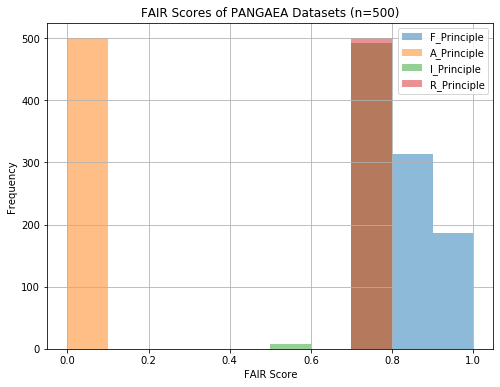

In [230]:
df_hist.plot.hist(sharex=True,sharey=True,alpha=0.5,figsize = (8,6), title="FAIR Scores of PANGAEA Datasets (n=500)")
plt.xlabel('FAIR Score')

In [231]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(10,10))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    for i, feature in enumerate(features):
        c = next(palette)
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].plot.hist(bins=10, ax=ax, color=c)
        ax.set_title("FAIR Score - "+feature+ ' (n=' + str(len(df_hist))+')')
        ax.set(xlabel="Score", ylabel="Frequency")
    fig.tight_layout()  
    plt.show()

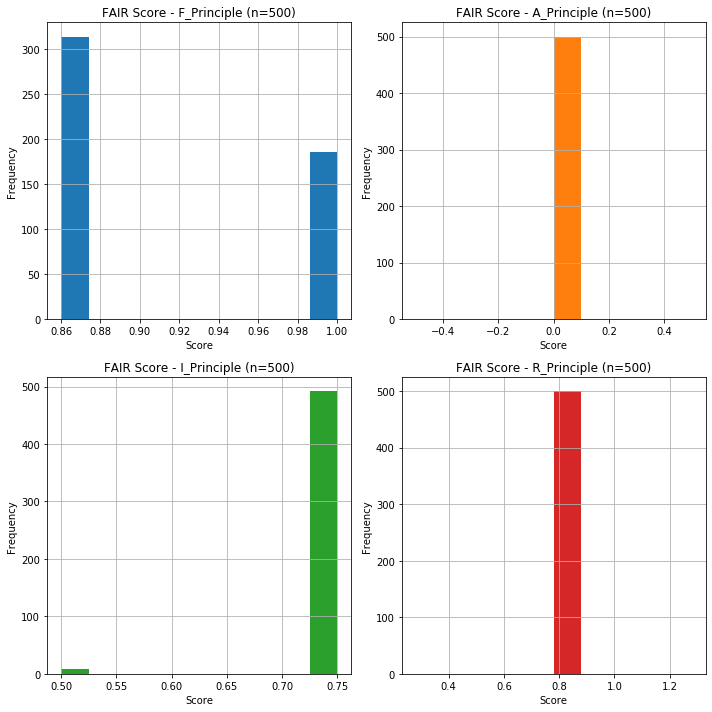

In [232]:
histograms_plot(df_hist,df_hist.columns[1:],2,2)

Inspect FINDABILITY 

In [233]:
#22 datasets < 0.8, e.g., https://doi.org/10.1594/PANGAEA.863175
#Missing core metadata ['summary']
# HTTPError code 401 (identifier included, but not accessible, restrcited data)
df_hist[df_hist.F_Principle <0.8]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


In [234]:
df_hist[(df_hist.F_Principle > 0.8) & (df_hist.F_Principle < 0.9)]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.1594/PANGAEA.864717,0.86,0.0,0.75,0.78
1,https://doi.org/10.1594/PANGAEA.429817,0.86,0.0,0.75,0.78
2,https://doi.org/10.1594/PANGAEA.400185,0.86,0.0,0.75,0.78
3,https://doi.org/10.1594/PANGAEA.130277,0.86,0.0,0.75,0.78
4,https://doi.org/10.1594/PANGAEA.137862,0.86,0.0,0.75,0.78
...,...,...,...,...,...
492,https://doi.org/10.1594/PANGAEA.439783,0.86,0.0,0.75,0.78
493,https://doi.org/10.1594/PANGAEA.141183,0.86,0.0,0.75,0.78
495,https://doi.org/10.1594/PANGAEA.626525,0.86,0.0,0.75,0.78
496,https://doi.org/10.1594/PANGAEA.759085,0.86,0.0,0.75,0.78


Inspect ACCESSBILITY

In [235]:
df_hist[df_hist.A_Principle <0.8]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.1594/PANGAEA.864717,0.86,0.0,0.75,0.78
1,https://doi.org/10.1594/PANGAEA.429817,0.86,0.0,0.75,0.78
2,https://doi.org/10.1594/PANGAEA.400185,0.86,0.0,0.75,0.78
3,https://doi.org/10.1594/PANGAEA.130277,0.86,0.0,0.75,0.78
4,https://doi.org/10.1594/PANGAEA.137862,0.86,0.0,0.75,0.78
...,...,...,...,...,...
495,https://doi.org/10.1594/PANGAEA.626525,0.86,0.0,0.75,0.78
496,https://doi.org/10.1594/PANGAEA.759085,0.86,0.0,0.75,0.78
497,https://doi.org/10.1594/PANGAEA.397957,1.00,0.0,0.75,0.78
498,https://doi.org/10.1594/PANGAEA.394343,1.00,0.0,0.75,0.78


In [236]:
#https://doi.org/10.1594/PANGAEA.863175
# Datacite schema: "rights": "Data access is restricted (moratorium, sensitive data, license constraints)"
df_hist[df_hist.A_Principle > 0.8]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


Inspect INTEROPERABILITY

In [237]:
df_hist[df_hist.I_Principle < 0.6]
#NO RDF metadata available - https://doi.org/10.1594/PANGAEA.805126
##No related resource(s) found

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
101,https://doi.org/10.1594/PANGAEA.805126,1.00,0.0,0.5,0.78
149,https://doi.org/10.1594/PANGAEA.713179,0.86,0.0,0.5,0.78
180,https://doi.org/10.1594/PANGAEA.269078,1.00,0.0,0.5,0.78
235,https://doi.org/10.1594/PANGAEA.911386,1.00,0.0,0.5,0.78
262,https://doi.org/10.1594/PANGAEA.58831,0.86,0.0,0.5,0.78
298,https://doi.org/10.1594/PANGAEA.357018,0.86,0.0,0.5,0.78
425,https://doi.org/10.1594/PANGAEA.388605,0.86,0.0,0.5,0.78
467,https://doi.org/10.1594/PANGAEA.771485,0.86,0.0,0.5,0.78


In [238]:
df_hist[df_hist.I_Principle > 0.6] #https://doi.org/10.1594/PANGAEA.864717

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.1594/PANGAEA.864717,0.86,0.0,0.75,0.78
1,https://doi.org/10.1594/PANGAEA.429817,0.86,0.0,0.75,0.78
2,https://doi.org/10.1594/PANGAEA.400185,0.86,0.0,0.75,0.78
3,https://doi.org/10.1594/PANGAEA.130277,0.86,0.0,0.75,0.78
4,https://doi.org/10.1594/PANGAEA.137862,0.86,0.0,0.75,0.78
...,...,...,...,...,...
495,https://doi.org/10.1594/PANGAEA.626525,0.86,0.0,0.75,0.78
496,https://doi.org/10.1594/PANGAEA.759085,0.86,0.0,0.75,0.78
497,https://doi.org/10.1594/PANGAEA.397957,1.00,0.0,0.75,0.78
498,https://doi.org/10.1594/PANGAEA.394343,1.00,0.0,0.75,0.78


Inspect REUSABILITY

In [239]:
df_hist[df_hist.R_Principle < 0.5] 
#https://doi.org/10.1594/PANGAEA.863175	, https://doi.org/10.1594/PANGAEA.739104
#Resource type specified - Dataset"
#NO object content available to perform file descriptors #retricted data
# no prov-o
# file format cannot be tested due to content uri not accessible

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


In [240]:
df_hist[df_hist.R_Principle > 0.5]
#https://doi.org/10.1594/PANGAEA.864717
#NO file size info available
# no prov-o

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://doi.org/10.1594/PANGAEA.864717,0.86,0.0,0.75,0.78
1,https://doi.org/10.1594/PANGAEA.429817,0.86,0.0,0.75,0.78
2,https://doi.org/10.1594/PANGAEA.400185,0.86,0.0,0.75,0.78
3,https://doi.org/10.1594/PANGAEA.130277,0.86,0.0,0.75,0.78
4,https://doi.org/10.1594/PANGAEA.137862,0.86,0.0,0.75,0.78
...,...,...,...,...,...
495,https://doi.org/10.1594/PANGAEA.626525,0.86,0.0,0.75,0.78
496,https://doi.org/10.1594/PANGAEA.759085,0.86,0.0,0.75,0.78
497,https://doi.org/10.1594/PANGAEA.397957,1.00,0.0,0.75,0.78
498,https://doi.org/10.1594/PANGAEA.394343,1.00,0.0,0.75,0.78
